In [1]:
from pathlib import Path

from joblib import Memory
import h5py
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

In [2]:
DATA_DIR = Path.cwd() / 'data/' # EMG signals
CACHE_DIR = Path.cwd() / 'cache/' # cache previously done computations (via joblib)

memory = Memory(CACHE_DIR)

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/ nyq, highcut/ nyq], btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def notch(notch_freq, samp_freq, quality_factor=30):
    b, a = iirnotch(notch_freq, quality_factor, samp_freq)
    return b, a

def notch_filter(data, notch_fs, fs, q=30):
    b, a = notch(notch_fs, fs, q)
    y = filtfilt(b, a, data)
    return y

@memory.cache
def filt_GRID(data, lowcut=20, highcut=500, fs=4000, order=3, notch_fs = 50, notch_q = 30):
    filt_out = np.zeros_like(data)
    for i in range(data.shape[0]):
        filt_out[i,:] = notch_filter(butter_bandpass_filter(data[i,:], lowcut, highcut, fs, order=order), notch_fs, fs, notch_q)
    return filt_out


In [4]:
def loadmat(filename):
    file = h5py.File(filename, 'r')
    return np.asarray(file['grid_crds']), np.asarray(file['out_mat'])

if1_grid_crds, if1_out_mat = loadmat(DATA_DIR / r'increasing-force-1.mat')
if2_grid_crds, if2_out_mat = loadmat(DATA_DIR / r'increasing-force-2.mat')
sf1_grid_crds, sf1_out_mat = loadmat(DATA_DIR / r'steady-force-1.mat')

emg = if1_out_mat

In [5]:
print(emg.shape)

(60160, 64)


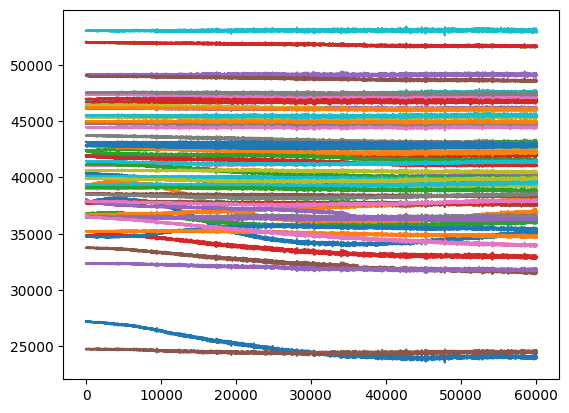

In [6]:
for i in range(emg.shape[1]):
    plt.plot(emg[:, i])
plt.show()

In [7]:
filtered_if1_out_mat = filt_GRID(emg)

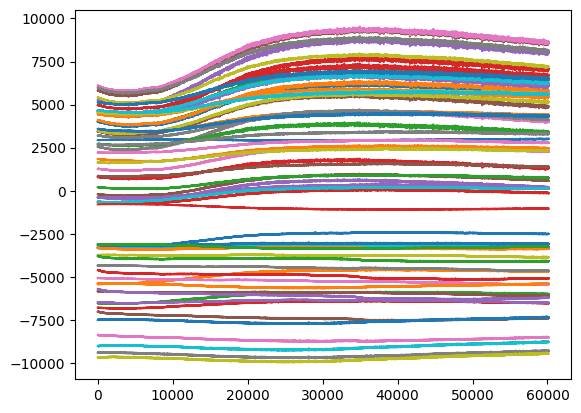

In [8]:
for i in range(filtered_if1_out_mat.shape[1]):
    plt.plot(filtered_if1_out_mat[:, i])
plt.show()

In [29]:
fastica = FastICA(n_components=filtered_if1_out_mat.shape[1])
ica_fit = memory.cache(fastica.fit)

In [30]:
fastica_model = ica_fit(filtered_if1_out_mat)
IC = fastica_model.transform(filtered_if1_out_mat)
print(IC)

[[-0.38021683  1.7731052  -0.16994487 ... -0.12592068  0.23412153
   0.07149857]
 [-0.46756175  0.76051523 -0.22889279 ... -0.60899072  0.14294467
   0.37667889]
 [-0.24163937  2.0185689  -0.7096824  ... -1.23905552 -0.19134139
   0.6308276 ]
 ...
 [ 0.26452175 -0.29877447 -1.36472097 ... -0.85544115  1.03601741
  -0.15806862]
 [ 0.18549762 -0.88777924 -1.69837222 ...  0.28089081  0.77909211
  -0.48020776]
 [-0.4861145   0.27520752 -1.64794922 ...  0.67614746  0.43956073
  -0.49661649]]


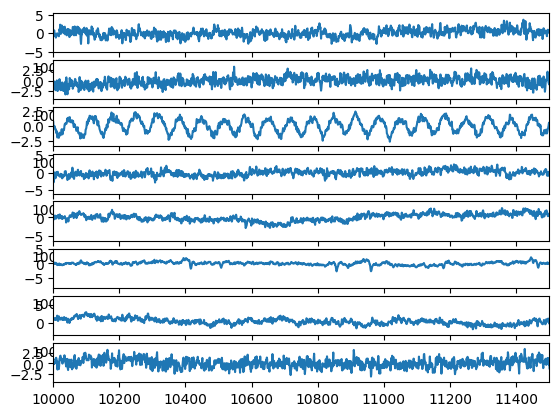

In [31]:
fig, ax = plt.subplots(nrows=IC.shape[1]//8)
for i in range(0, IC.shape[1]//8):
    ax[i].plot(IC[:, i])
    ax[i].set_xlim(left=10000, right=10000+1500)
plt.show()

In [53]:
fastica = FastICA(n_components=7)
ica_fit = fastica.fit

first_row = filtered_if1_out_mat[:, 5::8]

fastica_model = ica_fit(first_row)
IC = fastica_model.transform(first_row)

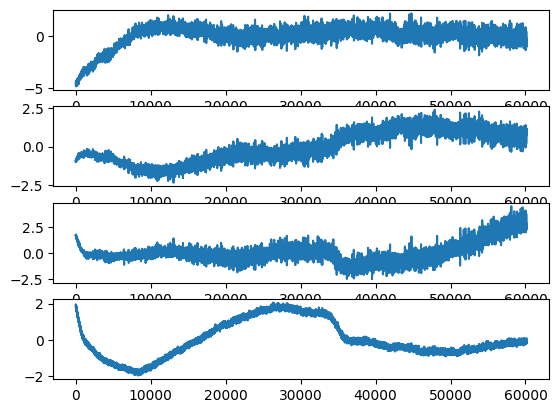

In [54]:
fig, ax = plt.subplots(nrows=IC.shape[1])
for i in range(0, IC.shape[1]):
    ax[i].plot(IC[:, i])
plt.show()